In [7]:
import os
import sys
sys.path.insert(0, os.path.join(os.getenv("HOME"), "linked-data-latex"))

import logging
logging.basicConfig(level="INFO")

import pandas as pd
from matplotlib import pylab as plt
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord

In [ ]:
# oda:version "v0.1.0"

In [8]:

from ddpaper.draftdata import load_globals

load_globals("eventinfo", globals())


        59861.532764       -1.132263e-08
        59861.532875       -2.860962e-08
        59861.532967        8.372585e-09
        59861.533060        2.639475e-08
        59861.533152        5.800138e-08
        59861.533243        7.682774e-09
        59861.533336       -2.288027e-08
        59861.533427       -2.711575e-08
        59861.533519       -1.538258e-09
        59861.533612       -4.196331e-08


[]

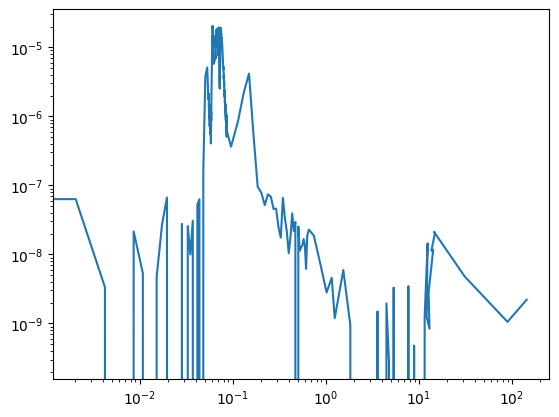

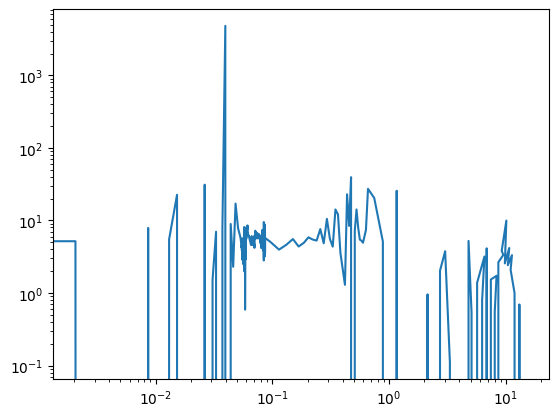

In [13]:
plt.figure()

!head picsit/grb221009a_afterglow_picsit_lc.txt

picsit_lc = pd.read_csv("picsit/grb221009a_afterglow_picsit_lc.txt", delim_whitespace=True, names=["mjd", "flux"])
picsit_hr = pd.read_csv("picsit/grb221009a_afterglow_picsit_hr.txt", delim_whitespace=True, names=["mjd", "hr"])

plt.plot(
    (picsit_lc.mjd - (T0_ijd + 51544))*24, 
    picsit_lc.flux, 
)

plt.loglog()

plt.figure()

plt.plot(
    (picsit_hr.mjd - (T0_ijd + 51544))*24, 
    picsit_hr.hr, 
)

plt.loglog()

In [ ]:
from odafunction.executors import default_execute_to_value
from odafunction.func.urifunc import URIipynbFunction, URIValue

focus_obs_name='total_3p'

# TODO: set version restriction here
# TODO: make nb2workflow store in remote storages
# TODO: make possible to disrupt equivalence with indications
# TODO: make common fd/fc depending on

v = default_execute_to_value(URIipynbFunction.from_generic_uri("file:///home/savchenk/grb221009/grbbase.ipynb")(focus_obs_name=focus_obs_name), valueclass=URIValue, cached=True)

import io
import tempfile
import base64
import tarfile
    
with tarfile.open(v['output_values']['fits_pack_url'].replace("file://", "")) as tar:
    tar.extractall(path=f"grbbase_fitspack_lc_{focus_obs_name}")

!ls -ltor grbbase_fitspack_lc*/*lc*fits

-rw-rw-r-- 1 savchenk 23040 Feb  6 23:17 grbbase_fitspack_lc_total_3p/JMX1_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk 23040 Feb  6 23:17 grbbase_fitspack_lc_total_3p/JMX2_lc_GRB221009A.fits
-rw-rw-r-- 1 savchenk 28800 Feb  6 23:17 grbbase_fitspack_lc_total_3p/IBIS_lc_GRB221009A.fits


In [25]:
from astropy.time import Time

T0_isot = v['output_values']['data']['T0_isot']
T0_ijd = Time(T0_isot).mjd - 51544

In [57]:
import numpy as np
from rebin import rebin_in_bins



/home/savchenk/miniconda-recent/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/savchenk/miniconda-recent/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3628094/2634386220.py:23: RuntimeWarning: invalid value encountered in double_scalars
  re = rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x))


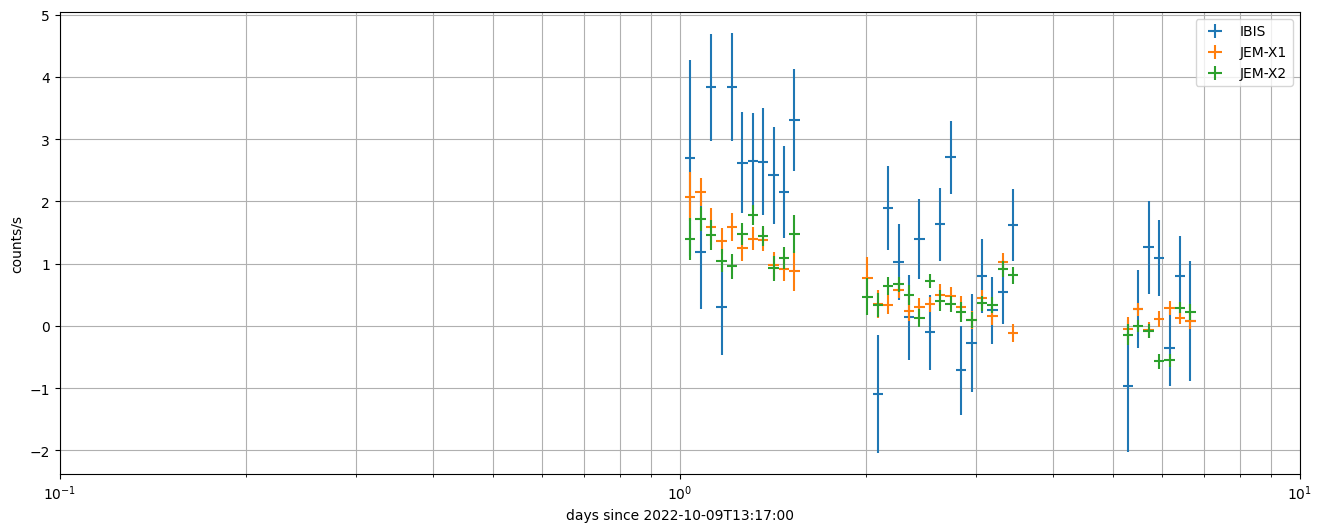

In [68]:
from astropy.io import fits


T = np.logspace(-1, 1, 120)
Tc = (T[1:] + T[:-1])/2.
dT = (T[1:] - T[:-1])/2.

plt.figure(figsize=(16, 6))

ijd2plot = lambda t:(t- T0_ijd)


for label, d in [('IBIS', fits.open("grbbase_fitspack_lc_total_3p/IBIS_lc_GRB221009A.fits")[1].data),
                 ('JEM-X1', fits.open("grbbase_fitspack_lc_total_3p/JMX1_lc_GRB221009A.fits")[1].data),
                 ('JEM-X2', fits.open("grbbase_fitspack_lc_total_3p/JMX2_lc_GRB221009A.fits")[1].data)
                ]:

    # plt.errorbar(ijd2plot(isgri_lc['TIME']), isgri_lc['RATE'], isgri_lc['ERROR'])

    d['RATE'][d['ERROR'] > np.nanmedian(d['ERROR'])*10] = np.NaN    

    r = rebin_in_bins(d['TIME'] - T0_ijd, d['RATE'], T)
    re = rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x))

    m = re < np.nanmedian(re)*3

    plt.errorbar(
        Tc[m], 
        r[m],
        re[m],
        xerr=dT[m],
        label=label,
        ls=""
    )

plt.xlim([0.1, 10])
plt.grid(which='both')

plt.legend()

plt.xlabel(f"days since {T0_isot}")
plt.ylabel("counts/s")

plt.semilogx()

plt.savefig("lc.png")
plt.savefig("lc.pdf")

# TODO: plot early AG SPI-ACS and PICsIT
# TODO: plot model fit
# TODO: plot rings contribution approx


In [67]:
lc_pdf="lc.pdf"